<a href="https://colab.research.google.com/github/Kevin-gram/Sound-Dataset-Clustering/blob/main/clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [2]:
#Make allNecessary Imports
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist


### load the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Extracts Mel Spectrogram features from all .wav files in the unlabelled_sound directory and stores them in a NumPy array.

In [16]:
# Load the Data
unlabelled_sound = "/content/drive/MyDrive/unlabelled_sounds"

# Function to extract Mel Spectrogram features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db, axis=1)  # The mean across time axis

#Extract Features the files
features = []
file_names = []

for file in os.listdir(unlabelled_sound):
    if file.endswith(".wav"):
        file_path = os.path.join(unlabelled_sound, file)
        feature = extract_features(file_path)
        features.append(feature)
        file_names.append(file)

features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1884
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2005
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Extracted features shape: (3000, 128)


#### Plots a scatter plot of the first two features from `features_array` without applying dimensionality reduction.


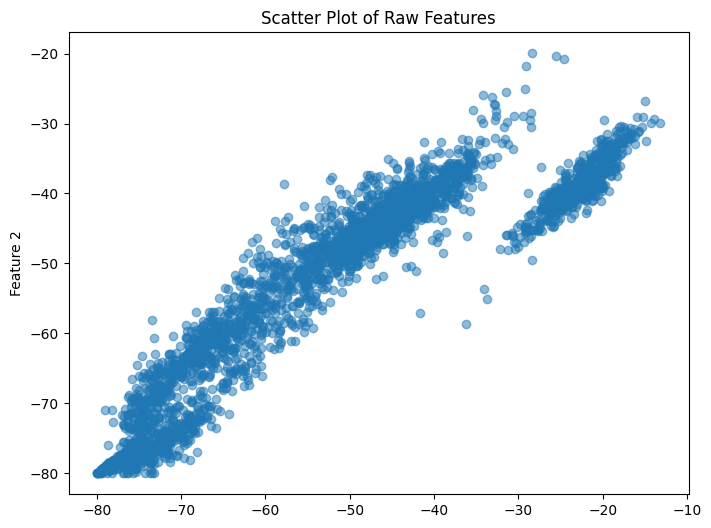

In [19]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.5)
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features")
plt.show()

### Creates a DataFrame using the first five features from `features_array` and visualizes their relationships using a pair plot.

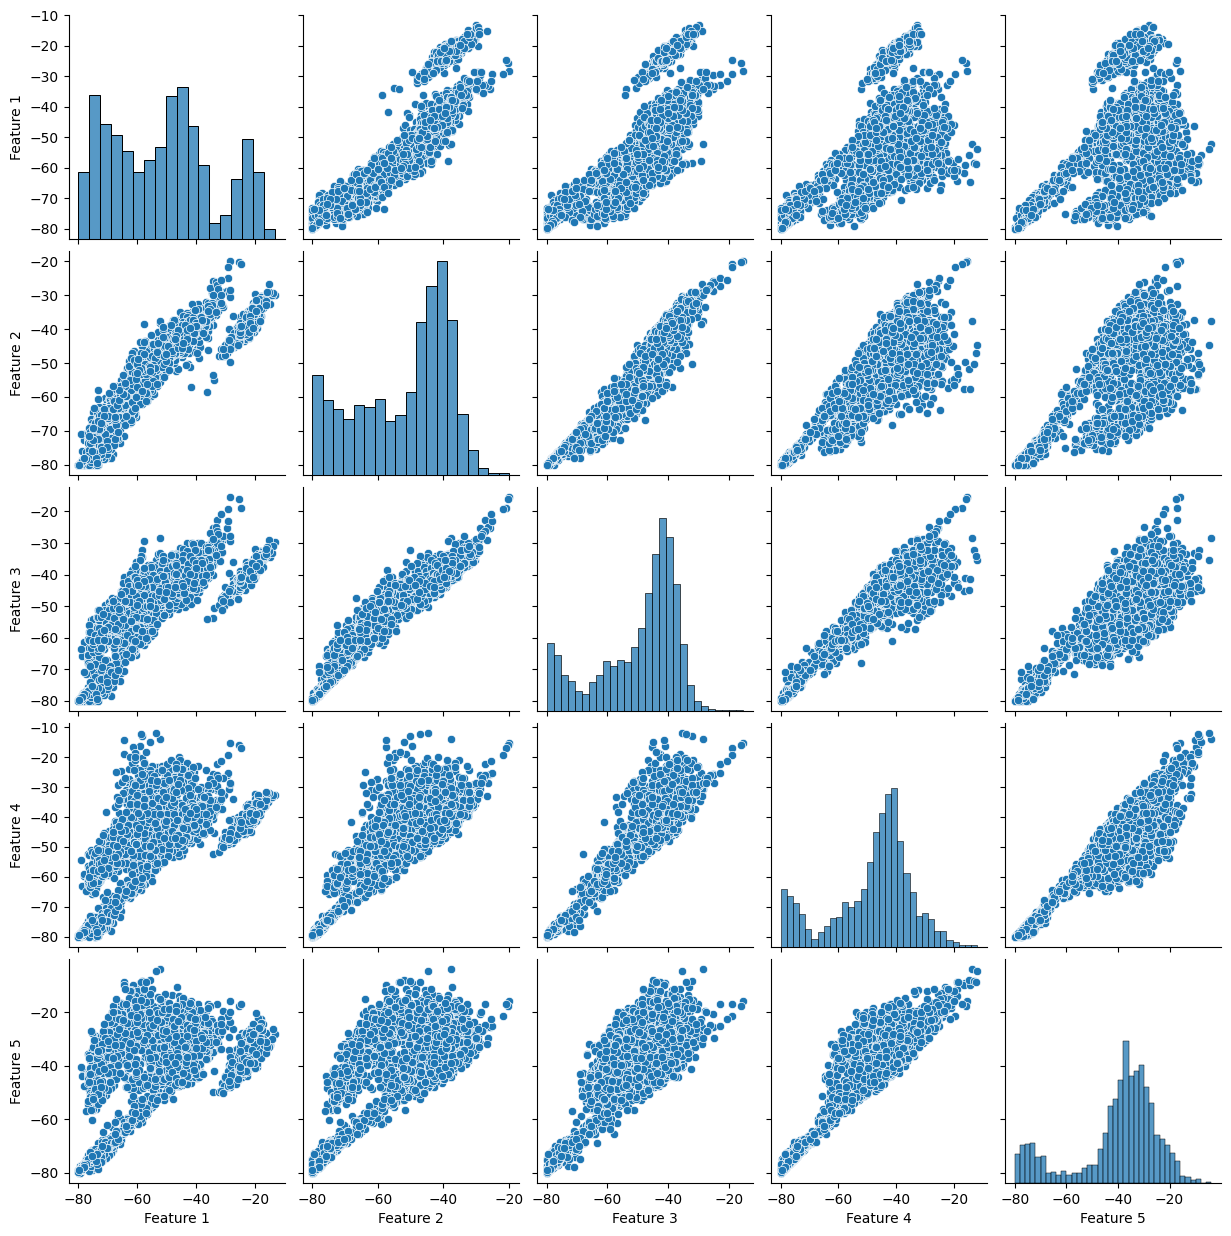

In [6]:
# Convert to DataFrame for pairplot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i}" for i in range(1, 6)])
sns.pairplot(df)
plt.show()

#### Applies PCA and t-SNE for dimensionality reduction to 3 components and visualizes the transformed features using 3D scatter plots.

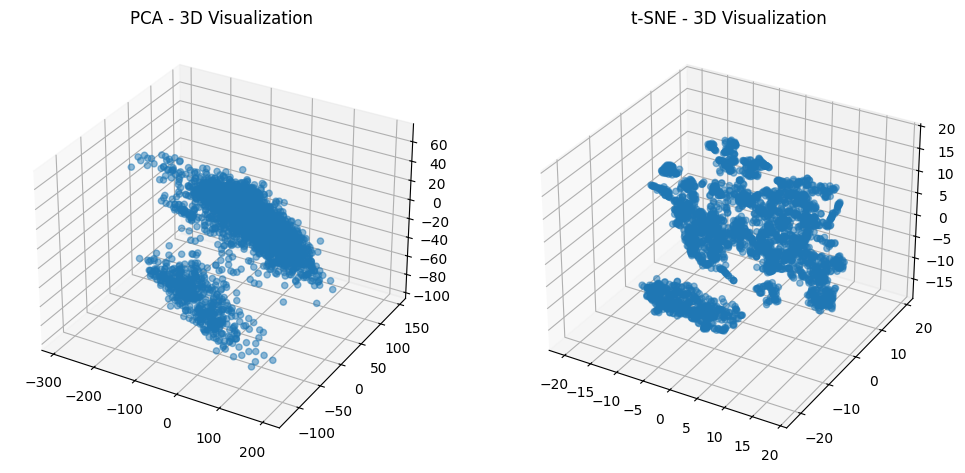

In [22]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

fig = plt.figure(figsize=(12, 6))

# For PCA
ax = fig.add_subplot(121, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax.set_title("PCA - 3D Visualization")

# For t-SNE
ax = fig.add_subplot(122, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax.set_title("t-SNE - 3D Visualization")

plt.show()


#### Uses the Elbow Method to determine the optimal number of clusters by applying K-Means on PCA-transformed features and plotting the distortion values for different K values.

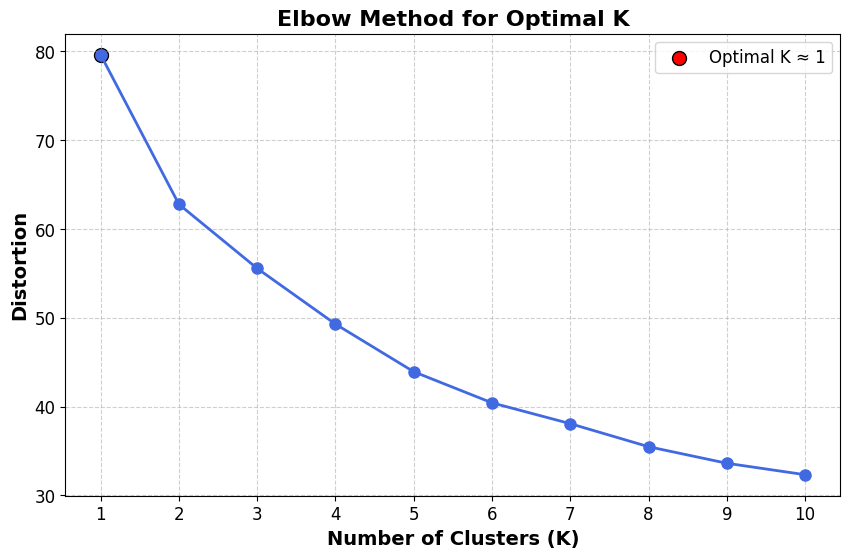

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Initialize list to store distortions
distortions = []
K_range = range(1, 11)

# Compute distortions for each K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)
    distortions.append(
        np.mean(np.min(cdist(features_pca, kmeans.cluster_centers_, "euclidean"), axis=1))
    )

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, marker="o", linestyle="-", color="royalblue", markersize=8, linewidth=2)
plt.xticks(K_range, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Number of Clusters (K)", fontsize=14, fontweight="bold")
plt.ylabel("Distortion", fontsize=14, fontweight="bold")
plt.title("Elbow Method for Optimal K", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)

# Annotate the "elbow" point (approximate optimal K visually)
optimal_k = np.argmin(np.gradient(distortions)) + 1
plt.scatter(optimal_k, distortions[optimal_k - 1], color="red", s=100, edgecolors="black", label=f"Optimal K ≈ {optimal_k}")
plt.legend(fontsize=12)

plt.show()




#### Applies K-Means (with an optimal K from the Elbow Method) and DBSCAN for clustering, then visualizes the clusters using scatter plots of PCA-reduced features.

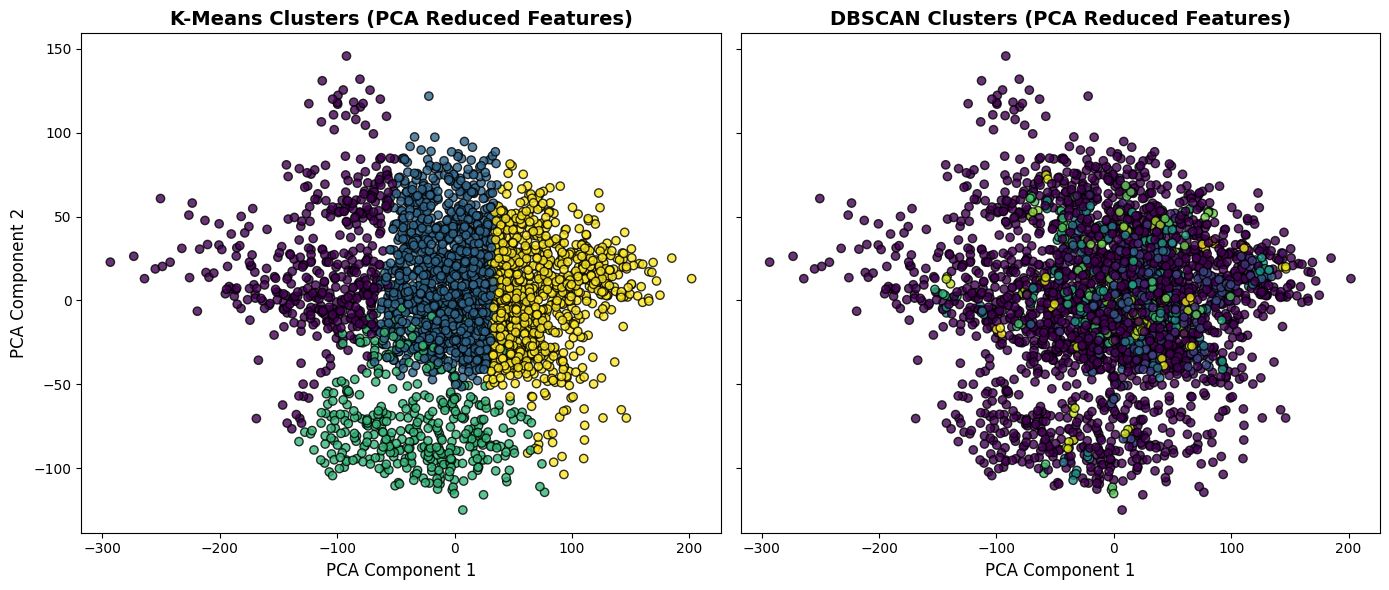

In [25]:

# Select optimal K based on elbow method
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Define a color map for better visuals
cmap = plt.get_cmap("viridis")

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Scatter plot for K-Means
scatter1 = axes[0].scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap=cmap, edgecolors="k", alpha=0.8)
axes[0].set_title("K-Means Clusters (PCA Reduced Features)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("PCA Component 1", fontsize=12)
axes[0].set_ylabel("PCA Component 2", fontsize=12)

# Scatter plot for DBSCAN
scatter2 = axes[1].scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap=cmap, edgecolors="k", alpha=0.8)
axes[1].set_title("DBSCAN Clusters (PCA Reduced Features)", fontsize=14, fontweight="bold")
axes[1].set_xlabel("PCA Component 1", fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

#### Evaluates K-Means and DBSCAN clustering performance using the Silhouette Score and Davies-Bouldin Index, handling cases where DBSCAN fails to form meaningful clusters.

In [10]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.3163, Davies-Bouldin Index: 1.0488
DBSCAN - Silhouette Score: -0.4259, Davies-Bouldin Index: 1.6851


####Plots a 2D scatter visualization of K-Means clusters using t-SNE-reduced features, coloring points based on their assigned cluster labels for better interpretability.

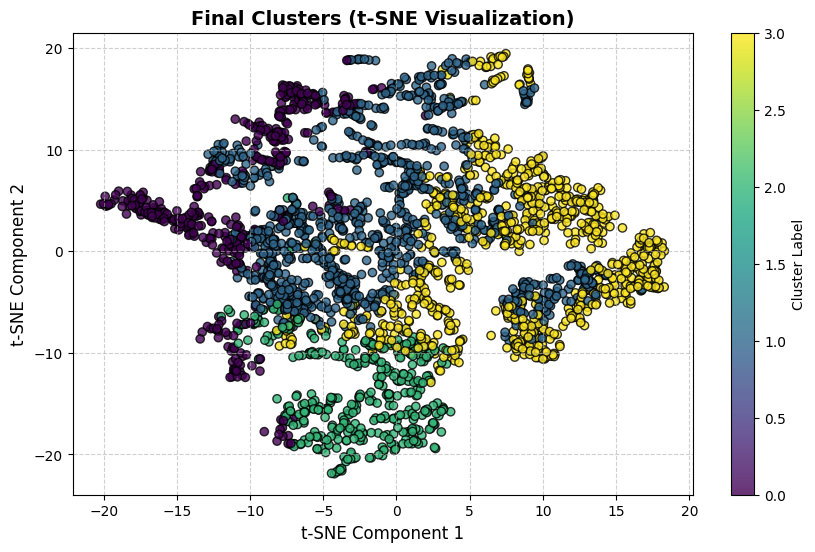

In [26]:

# Final visualization using t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    features_tsne[:, 0], features_tsne[:, 1],
    c=kmeans_labels, cmap="viridis", edgecolors="k", alpha=0.8
)

plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.title("Final Clusters (t-SNE Visualization)", fontsize=14, fontweight="bold")
plt.colorbar(scatter, label="Cluster Label")  # Add color legend
plt.grid(True, linestyle="--", alpha=0.6)  # Subtle grid for better readability

plt.show()


# Final Analysis

## 1. Why Dimensionality Reduction Helped in Clustering

Dimensionality reduction using **PCA** and **t-SNE** helped in clustering by simplifying the data structure while preserving essential patterns.

- **PCA** transformed high-dimensional Mel Spectrogram features into three principal components, reducing noise and redundancy.  
- **t-SNE** helped in visualizing clusters in 2D and 3D, making patterns more interpretable.  

> Without dimensionality reduction, clustering in high-dimensional space would suffer from the **curse of dimensionality**, making distance-based methods less effective.

## 2. Justification for Clustering Methods

- **K-Means performed well** because the data likely had compact, spherical clusters, making it easier for K-Means to assign points based on proximity to centroids.  
- **DBSCAN struggled** (as indicated by its failure to form meaningful clusters in some cases) because it is density-based and may not have worked well with PCA-transformed data that lacks clearly defined density regions. The choice of `eps=5` might also have affected its ability to detect clusters properly.  
- The **Silhouette Score and Davies-Bouldin Index** confirmed that K-Means found more distinct clusters than DBSCAN.  

## 3. Real-World Clustering Challenges

- **Selecting the right number of clusters (K) is difficult**: The **Elbow Method** helped, but in real-world applications, clusters may not always be well-defined.  
- **Dimensionality reduction is crucial for high-dimensional data**: Many real-world datasets (e.g., speech recognition, image processing) have thousands of features, making feature extraction and reduction necessary before clustering.  
- **Choosing the right clustering method matters**: K-Means works well when clusters are compact, but real-world sound data might require **hierarchical or density-based clustering (like DBSCAN) with tuned parameters** to detect varying shapes and densities.  

## Conclusion

**PCA successfully improved clustering**, making K-Means effective, while **DBSCAN struggled** due to the density-based nature of the transformed data.  
Real-world clustering requires careful **preprocessing, feature selection, and algorithm choice** to get meaningful results.
